# Averaged data

In [3]:
from pandas import HDFStore, DataFrame, Series, IndexSlice
from tqdm.auto import tqdm
from pandas import concat
from itertools import product

from sys import path
path.append("../")
from src.feature_extraction.eda import EDA_FEATURE_NAMES

eda_components = ['mixed-EDA', 'phasic-EDA', 'tonic-EDA']


def load_averaged_data(path: str) -> tuple[DataFrame, Series, Series]:
    loaded_data: dict[str, DataFrame] = {}

    # Open the HDF5 file
    with HDFStore(path) as store:
        # Iterate through the keys (group names) in the HDF5 file
        for key in tqdm(store.keys(), desc='Loading data'):
            # Load each DataFrame and store it in the dictionary
            loaded_data[key] = store[key]

    concated_df_avgs = concat(
        [loaded_data[key].loc[:, IndexSlice["Average", :]] for key in loaded_data.keys()],
        axis=1,
        keys=[el[1:] for el in loaded_data.keys()],
    )
    concated_df_errs = concat(
        [loaded_data[key].loc[:, IndexSlice["Standard error", :]] for key in loaded_data.keys()],
        axis=1,
        keys=[el[1:] for el in loaded_data.keys()],
    )
    df_avgs = concated_df_avgs.stack(level=[0,1]).reset_index(drop=False)
    df_avgs = df_avgs.drop(labels=['level_2'], axis=1, inplace=False)
    
    df_avgs.columns = ["classifier", "side", "Balanced Accuracy", *list(product(eda_components, EDA_FEATURE_NAMES))]

    df_errs = concated_df_errs.stack(level=[0,1]).reset_index(drop=False)
    df_errs = df_errs.drop(labels=['level_2'], axis=1, inplace=False)
    df_errs.columns = ["classifier", "side", "Balanced Accuracy", *list(product(eda_components, EDA_FEATURE_NAMES))]
    upper_errs = df_errs["Balanced Accuracy"]
    lower_errs = df_errs["Balanced Accuracy"]
    return df_avgs, upper_errs, lower_errs, df_errs
    
def make_linerrorplot(data: DataFrame, lower_errs: Series, upper_errs: Series, path_to_save: str) -> None:
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    
    plt.figure(figsize=(3, 7))
    sns.set_style("darkgrid")
    
    palette = sns.color_palette("colorblind")
    # sns.scatterplot(data=df, x='side', y='Balanced Accuracy', hue='classifier')
    plt.errorbar(
        x=data["side"],
        y=data["Balanced Accuracy"],
        xerr=None,
        yerr=(lower_errs, upper_errs),
        # label=custom_label,
        elinewidth=5,
        linestyle="none",
        markersize=1,
        marker=".",
        color=palette[0],
        ecolor=(*palette[0], 0.3),
    )
    plt.ylim(0.5, 1.0)
    
    plt.savefig(path_to_save, bbox_inches="tight")
    plt.show()
    # legend off
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    # 

## USILaughs - all max resources

In [4]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/nested_loso_xgboost_featureselection_avg.h5"
# Create an empty dictionary to store the loaded DataFrames
df_avgs, upper_errs, lower_errs, df_errs = load_averaged_data(path_to_save_data_avgs)

Loading data:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
df_avgs['classifier'].nunique()

1

In [6]:
df_avgs['classifier'].unique()

array(['XGBClassifier'], dtype=object)

In [7]:
display(
    concat([df_errs["Balanced Accuracy"], df_avgs], axis=1, keys=["errors", "averages"])
    .groupby(("averages", "side"))
    .max()*100
)



errors  \
                 Balanced Accuracy   
(averages, side)                     
left                      0.375120   
lxrx                      0.275907   
right                     0.310653   
rxlx                      0.423046   

                                                           averages  \
                                                         classifier   
(averages, side)                                                      
left              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
lxrx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right             XGBClassifierXGBClassifierXGBClassifierXGBClas...   
rxlx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   

                                                          \
                 Balanced Accuracy (mixed-EDA, min_feat)   
(averages, side)                                           
left                     62.192222              4.036884   
lxrx                     74.479778              4.036884   
right                    74.619778             12.000082   
rxlx                     68.018444             12.000082   

                                                               \
                 (mixed-EDA, max_feat) (mixed-EDA, mean_feat)   
(averages, side)                                                
left                          3.474613               1.974477   
lxrx                          3.474613               1.974477   
right                         2.466064               1.912872   
rxlx                          2.466064               1.912872   

                                                                        \
                 (mixed-EDA, std_feat) (mixed-EDA, dynamic_range_feat)   
(averages, side)                                                         
left                          2.181142                        1.538214   
lxrx                          2.181142                        1.538214   
right                         1.492600                        1.267375   
rxlx                          1.492600                        1.267375   

                                                                           \
                 (mixed-EDA, slope_feat) (mixed-EDA, absolute_slope_feat)   
(averages, side)                                                            
left                            1.724360                         2.136389   
lxrx                            1.724360                         2.136389   
right                           1.475397                         1.803877   
rxlx                            1.475397                         1.803877   

                  ...                          \
                  ... (tonic-EDA, slope_feat)   
(averages, side)  ...                           
left              ...                2.427327   
lxrx              ...                2.427327   
right             ...                1.675322   
rxlx              ...                1.675322   

                                                   \
                 (tonic-EDA, absolute_slope_feat)   
(averages, side)                                    
left                                     2.290158   
lxrx                                     2.290158   
right                                    1.947319   
rxlx                                     1.947319   

                                                          \
                 (tonic-EDA, first_derivetive_mean_feat)   
(averages, side)                                           
left                                            2.456285   
lxrx                                            2.456285   
right                                           1.851540   
rxlx                                            1.851540   

                                                         \
                 (tonic-EDA, first_derivative_std_feat)   
(averages, side)                                          
left         

In [8]:
df_errs*100

,classifier,side,Balanced Accuracy,"(mixed-EDA, min_feat)","(mixed-EDA, max_feat)","(mixed-EDA, mean_feat)","(mixed-EDA, std_feat)","(mixed-EDA, dynamic_range_feat)","(mixed-EDA, slope_feat)","(mixed-EDA, absolute_slope_feat)",...,"(tonic-EDA, slope_feat)","(tonic-EDA, absolute_slope_feat)","(tonic-EDA, first_derivetive_mean_feat)","(tonic-EDA, first_derivative_std_feat)","(tonic-EDA, number_of_peaks_feat)","(tonic-EDA, peaks_amplitude_feat)","(tonic-EDA, dc_term)","(tonic-EDA, sum_of_all_coefficients)","(tonic-EDA, information_entropy)","(tonic-EDA, spectral_energy)"
0,XGBClassifierXGBClassifierXGBClassifierXGBClas...,leftleftleftleftleftleftleftleftleftleftleftle...,0.375120,0.020066,0.014680,0.007348,0.010776,0.007726,0.009758,0.012273,...,0.007872,0.008496,0.012714,0.011971,0.005428,0.016217,0.024348,0.019555,0.009721,0.015311
1,XGBClassifierXGBClassifierXGBClassifierXGBClas...,lxrxlxrxlxrxlxrxlxrxlxrxlxrxlxrxlxrxlxrxlxrxlx...,0.275907,0.020066,0.014680,0.007348,0.010776,0.007726,0.009758,0.012273,...,0.007872,0.008496,0.012714,0.011971,0.005428,0.016217,0.024348,0.019555,0.009721,0.015311
2,XGBClassifierXGBClassifierXGBClassifierXGBClas...,rightrightrightrightrightrightrightrightrightr...,0.310653,0.073830,0.012201,0.008959,0.007798,0.006111,0.011762,0.010657,...,0.005006,0.006418,0.011745,0.015926,0.006419,0.006541,0.083583,0.018956,0.009082,0.007049
3,XGBClassifierXGBClassifierXGBClassifierXGBClas...,rxlxrxlxrxlxrxlxrxlxrxlxrxlxrxlxrxlxrxlxrxlxrx...,0.423046,0.073830,0.012201,0.008959,0.007798,0.006111,0.011762,0.010657,...,0.005006,0.006418,0.011745,0.015926,0.006419,0.006541,0.083583,0.018956,0.009082,0.007049


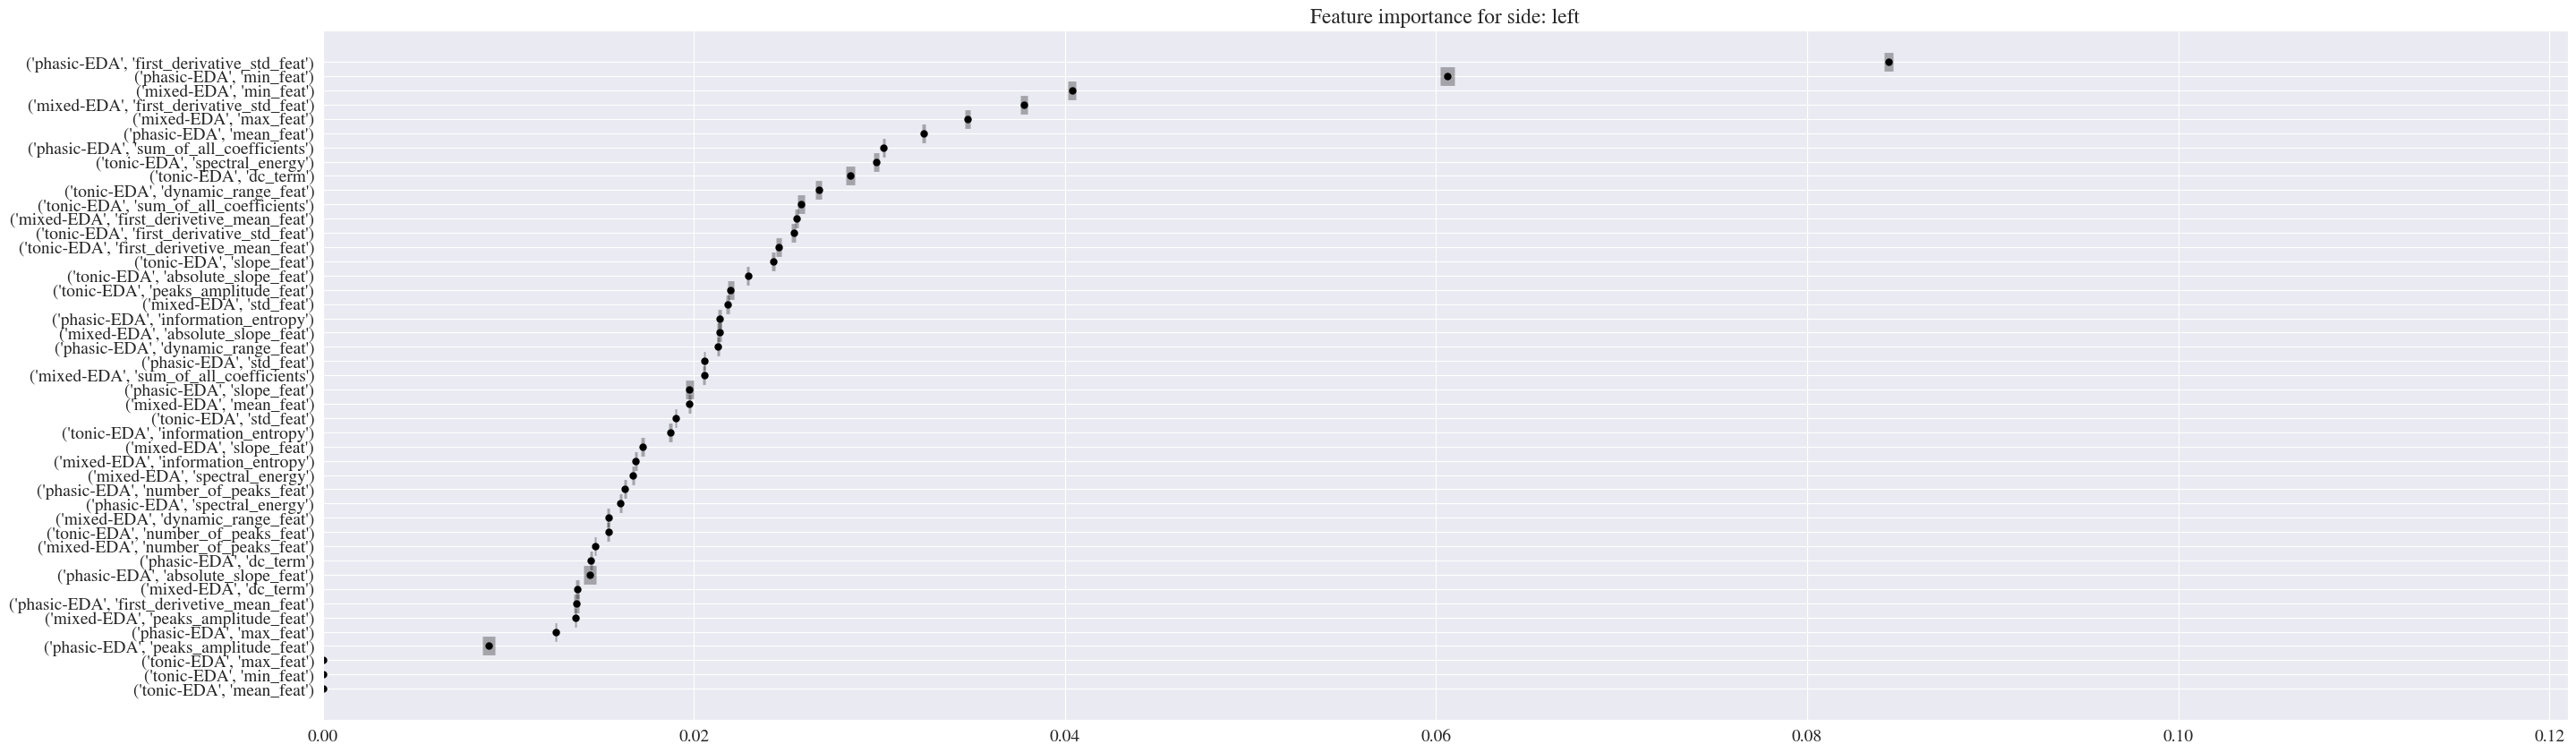

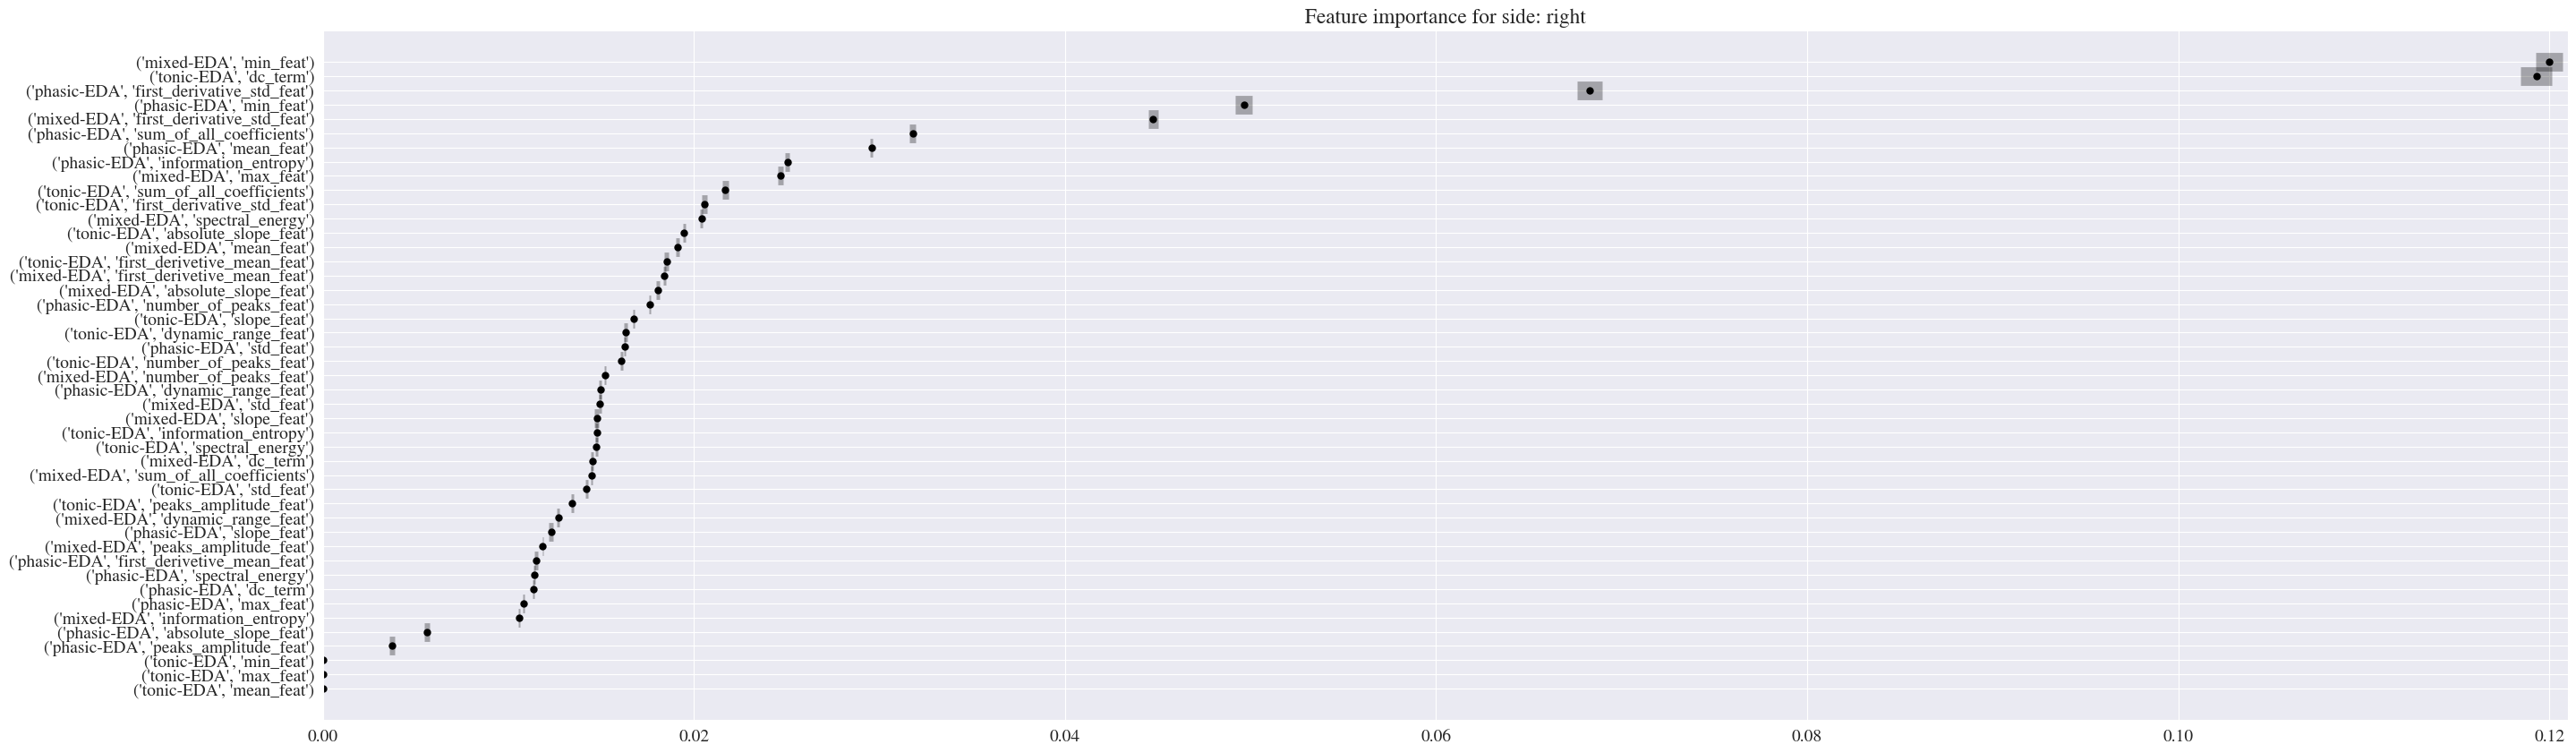

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

golden_ratio = (5**0.5 - 1) / 2
figsize = 10
# set seaborn style
sns.set_style("darkgrid")
# # set latex font
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
# increase font size
plt.rcParams.update({"font.size": 14})
plt.rcParams['axes.grid'] = True
    
for side in ["left", "right"]:
    fig, axs = plt.subplots(1, 1, figsize=(figsize / golden_ratio * 2, figsize))
    plt.title("Feature importance for side: {}".format(side))

    colors = sns.color_palette(
        "colorblind", n_colors=(len(df_avgs[df_avgs["side"] == side].iloc[0, 3:].index))
    )

    bounds = [el for el in df_errs[df_errs["side"] == side].iloc[0, 3:]]
    values = df_avgs[df_avgs["side"] == side].iloc[0, 3:].astype(float).values
    # lower_bounds = [el for el, val in zip(bounds, values)]
    # upper_bounds = [abs(val + el) for el, val in zip(bounds, values)]

    df_final = DataFrame((values, bounds, df_avgs[df_avgs["side"] == side].iloc[0, 3:].index)).T.sort_values(by=0, ascending=True)
    values = df_final[0].values
    bounds = df_final[1].values
    names = df_final[2].values
    df_final.sort_values(by=0, ascending=False).iloc[:,2].to_csv("../data.nosync/usilaughs/feature_importance/importance_xgboost_loso_{}.csv".format(side))
    
    axs.errorbar(
        y=[str(el) for el in names],
        x=values,
        xerr=(bounds, bounds),
        elinewidth=15,
        linestyle="none",
        markersize=10,
        marker=".",
        color=(0,0,0),
        ecolor=(*(0,0,0), 0.3),
    )
    # make seaborn barplot
    plt.xlim(0, 0.121)
    plt.savefig("../final_visualizations/feature_importance_xgboost_loso_{}.pdf".format(side), bbox_inches="tight")
    plt.show()

## MWC2022

In [13]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/nested_loso_xgboost_featureselection_avg.h5"
# Create an empty dictionary to store the loaded DataFrames
df_avgs, upper_errs, lower_errs, df_errs = load_averaged_data(path_to_save_data_avgs)

Loading data:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
display(
    concat([df_errs["Balanced Accuracy"], df_avgs], axis=1, keys=["errors", "averages"])
    .groupby(("averages", "side"))
    .max()*100
)


errors  \
                 Balanced Accuracy   
(averages, side)                     
left                      0.363840   
lxrx                      0.332451   
right                     0.325733   
rxlx                      0.416233   

                                                           averages  \
                                                         classifier   
(averages, side)                                                      
left              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
lxrx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right             XGBClassifierXGBClassifierXGBClassifierXGBClas...   
rxlx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   

                                                          \
                 Balanced Accuracy (mixed-EDA, min_feat)   
(averages, side)                                           
left                     74.358518              7.457926   
lxrx                     68.770123              7.457926   
right                    69.908127              5.449480   
rxlx                     73.075289              5.449480   

                                                               \
                 (mixed-EDA, max_feat) (mixed-EDA, mean_feat)   
(averages, side)                                                
left                          1.873051               1.422816   
lxrx                          1.873051               1.422816   
right                         4.151561               1.535354   
rxlx                          4.151561               1.535354   

                                                                        \
                 (mixed-EDA, std_feat) (mixed-EDA, dynamic_range_feat)   
(averages, side)                                                         
left                          1.690827                        1.650574   
lxrx                          1.690827                        1.650574   
right                         2.163473                        2.148597   
rxlx                          2.163473                        2.148597   

                                                                           \
                 (mixed-EDA, slope_feat) (mixed-EDA, absolute_slope_feat)   
(averages, side)                                                            
left                            1.500339                         1.574400   
lxrx                            1.500339                         1.574400   
right                           1.933670                         2.295504   
rxlx                            1.933670                         2.295504   

                  ...                          \
                  ... (tonic-EDA, slope_feat)   
(averages, side)  ...                           
left              ...                2.285811   
lxrx              ...                2.285811   
right             ...                2.885739   
rxlx              ...                2.885739   

                                                   \
                 (tonic-EDA, absolute_slope_feat)   
(averages, side)                                    
left                                     1.395742   
lxrx                                     1.395742   
right                                    1.629588   
rxlx                                     1.629588   

                                                          \
                 (tonic-EDA, first_derivetive_mean_feat)   
(averages, side)                                           
left                                            1.198488   
lxrx                                            1.198488   
right                                           1.414370   
rxlx                                            1.414370   

                                                         \
                 (tonic-EDA, first_derivative_std_feat)   
(averages, side)                                          
left         

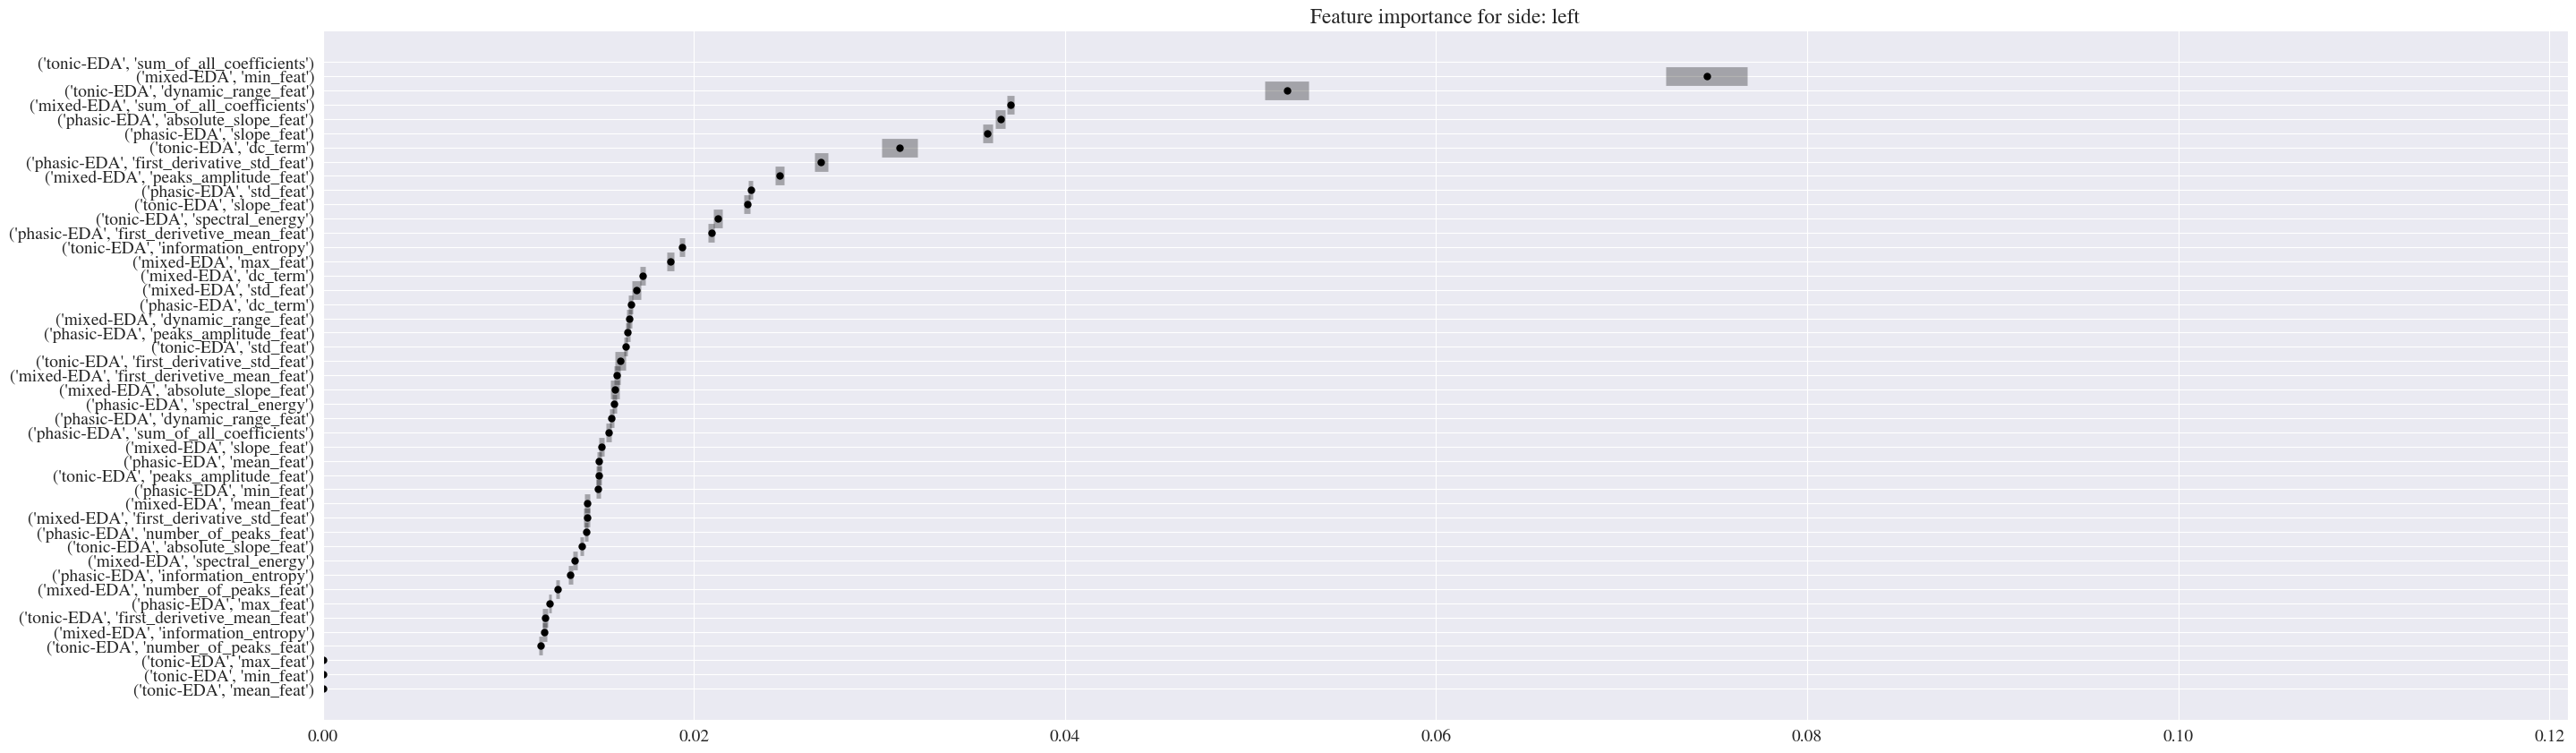

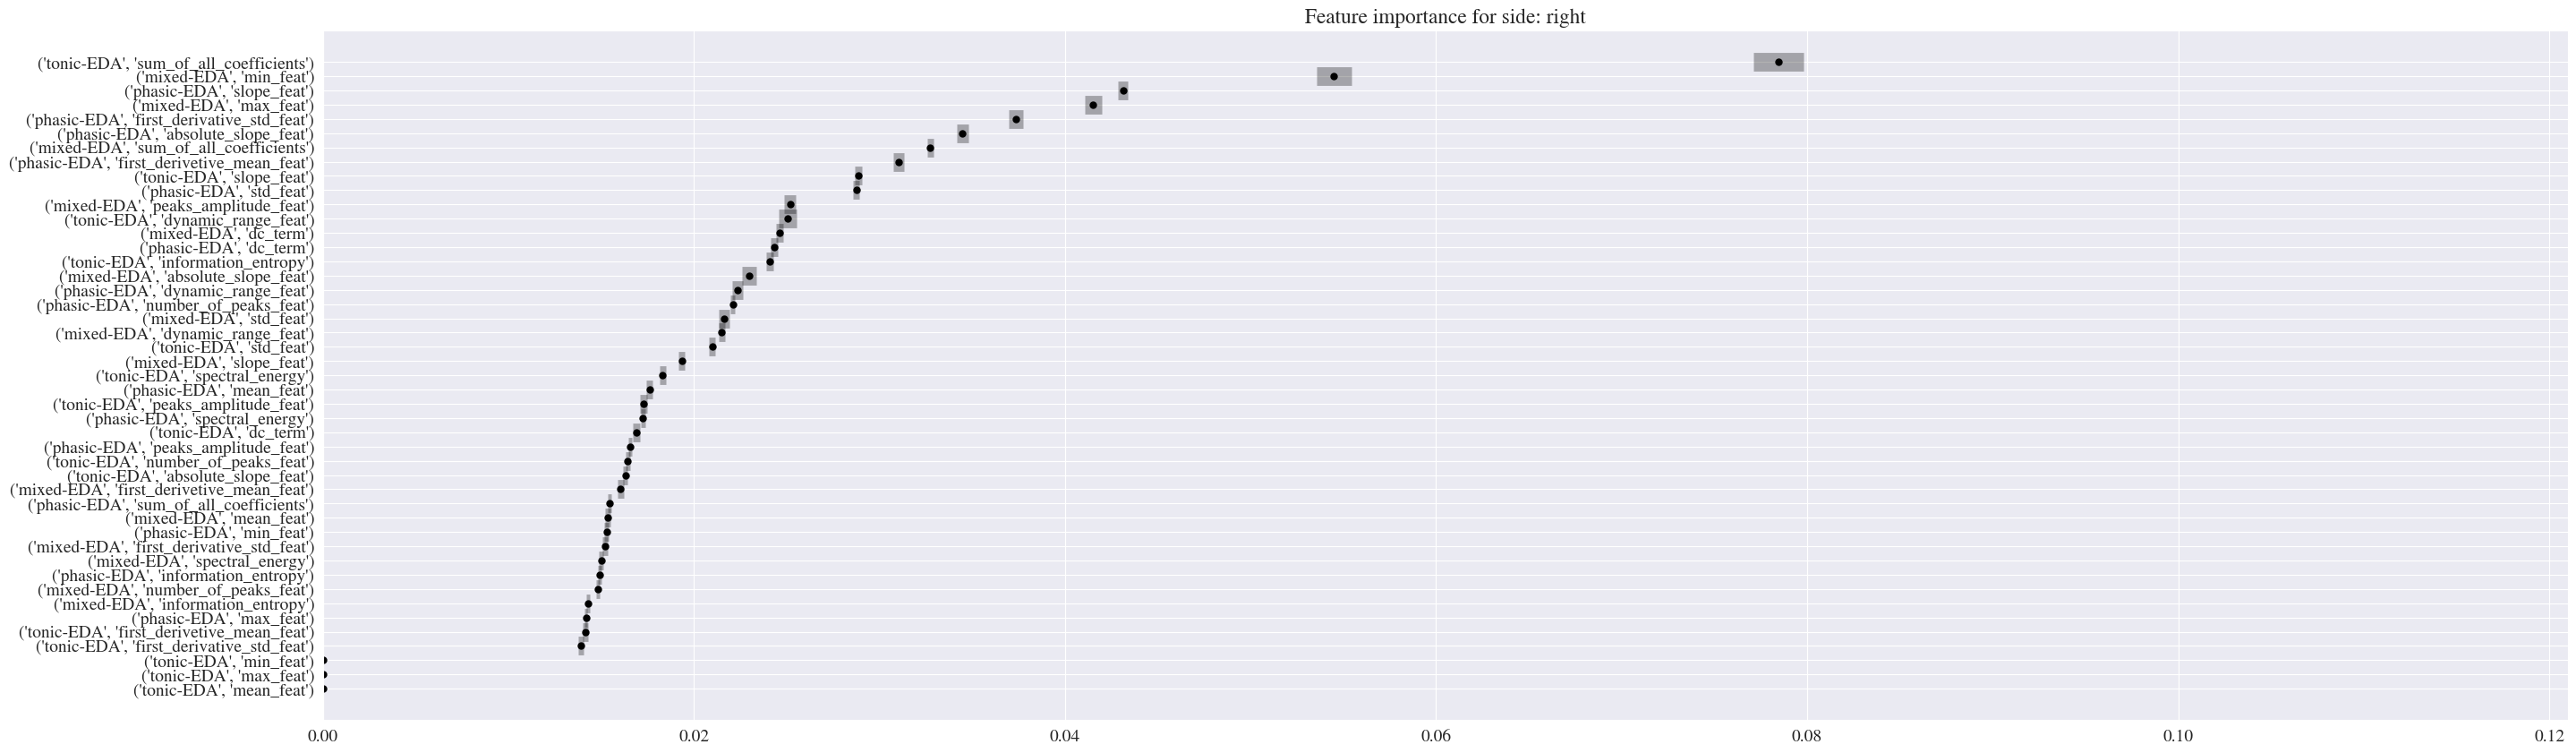

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

golden_ratio = (5**0.5 - 1) / 2
figsize = 10
# set seaborn style
sns.set_style("darkgrid")
# # set latex font
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
# increase font size
plt.rcParams.update({"font.size": 14})
plt.rcParams['axes.grid'] = True
    
for side in ["left", "right"]:
    fig, axs = plt.subplots(1, 1, figsize=(figsize / golden_ratio * 2, figsize))
    plt.title("Feature importance for side: {}".format(side))

    colors = sns.color_palette(
        "colorblind", n_colors=(len(df_avgs[df_avgs["side"] == side].iloc[0, 3:].index))
    )

    bounds = [el for el in df_errs[df_errs["side"] == side].iloc[0, 3:]]
    values = df_avgs[df_avgs["side"] == side].iloc[0, 3:].astype(float).values
    # lower_bounds = [el for el, val in zip(bounds, values)]
    # upper_bounds = [abs(val + el) for el, val in zip(bounds, values)]

    df_final = DataFrame((values, bounds, df_avgs[df_avgs["side"] == side].iloc[0, 3:].index)).T.sort_values(by=0, ascending=True)
    values = df_final[0].values
    bounds = df_final[1].values
    names = df_final[2].values
    df_final.sort_values(by=0, ascending=False).iloc[:,2].to_csv("../data.nosync/mwc2022/feature_importance/importance_xgboost_loso_{}.csv".format(side))
    
    axs.errorbar(
        y=[str(el) for el in names],
        x=values,
        xerr=(bounds, bounds),
        elinewidth=15,
        linestyle="none",
        markersize=10,
        marker=".",
        color=(0,0,0),
        ecolor=(*(0,0,0), 0.3),
    )
    # make seaborn barplot
    plt.xlim(0, 0.121)
    plt.savefig("../final_visualizations/feature_importance_xgboost_loso_{}_mwc2022.pdf".format(side), bbox_inches="tight")
    plt.show()

# Total data

In [1]:
from pandas import DataFrame, concat, MultiIndex, Series
from collections import defaultdict
from pandas import concat
from numpy import nanstd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import itertools
from pandas import HDFStore, DataFrame
from tqdm.auto import tqdm


def calculate_fold_df(data: DataFrame):
    avgs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).mean(axis=1)
    errs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).apply(lambda x: nanstd(x) / ((len(x - 1)) ** 0.5) if len(x) > 1 else 1, axis=1)
    return concat([avgs, errs], axis=1, keys=["Balanced Accuracy", "Standard Error"])


def concatenate_prepared_data(data: dict[str, DataFrame]) -> DataFrame:
    concated_df_dict: dict[DataFrame, Series] = {}
    sides: list[str] = ["left", "right", "lxrx", "rxlx"]
    for side in sides:
        concated_df_dict[side] = concat(
            [
                data[key][["Balanced Accuracy", "Standard Error"]].sort_index()
                for key in data.keys()
                if side in key
            ],
            axis=0,
            keys=[key[1:5] for key in data.keys() if side in key],
        )
        concated_df_dict[side].index = concated_df_dict[side].index.droplevel(0)

    all_results = concat(
        list(concated_df_dict.values()),
        axis=0,
        keys=sides,
        # ignore_index=True,
    )
    all_results = all_results.reset_index()
    all_results.columns = ["Side", "Model", "Balanced Accuracy", "Standard Error"]
    return all_results


def load_prepare_data(path_to_all_data: str) -> DataFrame:
    loaded_data = defaultdict(lambda: defaultdict(lambda: dict()))

    # Open the HDF5 file
    with HDFStore(path_to_save_data_avgs) as store:
        # Iterate through the keys (group names) in the HDF5 file
        for key in tqdm(store.keys(), desc="Loading data"):
            # Load each DataFrame and store it in the dictionary
            data = store[key]
            split_key = key.split("_")
            loaded_data[split_key[0]][split_key[1]][split_key[2]] = data

    loaded_data_correct = {
        f"{key1}_{key2}": calculate_fold_df(loaded_data[key1][key2])
        for key1 in loaded_data.keys()
        for key2 in loaded_data[key1].keys()
    }

    return concatenate_prepared_data(data=loaded_data_correct)


def remove_dummy(data: DataFrame) -> DataFrame:
    return data[data["Model"] != "DummyClassifier"]


def make_violin_accuracy(
    data: DataFrame,
    sides: list[str],
    path_to_save_fig: str,
    small_fontsize: int = 14,
    medium_fontsize: int = 18,
    large_fontsize: int = 20,
    xlim: tuple[float, float] | None = None,
):
    # set seaborn style
    sns.set_style("darkgrid")

    # # set latex font
    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    # plt.rcParams.update({"font.size": figsize *8})
    plt.rcParams["axes.grid"] = True

    # increase font size
    plt.rc("font", size=small_fontsize)  # controls default text sizes
    plt.rc("axes", titlesize=medium_fontsize)  # fontsize of the axes title
    plt.rc("axes", labelsize=large_fontsize)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("legend", fontsize=medium_fontsize)  # legend fontsize
    plt.rc("figure", titlesize=large_fontsize)  # fontsize of the figure title
    plt.rcParams.update({"font.size": medium_fontsize})

    ax = sns.violinplot(
        data=data,
        y="Train-Test",
        x="Balanced Accuracy",
        palette="colorblind",
        orient="h",
    )
    annotator = Annotator(
        ax,
        list(itertools.combinations(sides, 2)),
        data=data,
        x="Balanced Accuracy",
        y="Train-Test",
        orient="h",
        order=sides,
    )
    annotator.configure(
        test="Mann-Whitney",
        comparisons_correction="BH",
        text_format="star",
        loc="outside",
    )
    annotator.apply_and_annotate()

    # set vertical line at 0.5
    plt.axvline(x=0.5, color="black", linestyle="--", linewidth=1)
    if xlim:
        plt.xlim(xlim)
    plt.savefig(path_to_save_fig, bbox_inches="tight")
    plt.show()


def clean_side_names(
    data: DataFrame, renaming_dict: dict[str, str] | None = None
) -> DataFrame:
    if renaming_dict is None:
        renaming_dict = {
            "left": "Left-Left",
            "right": "Right-Right",
            "lxrx": "Left-Right",
            "rxlx": "Right-Left",
        }
    renaming_dict: dict[str, str]
    data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)
    return data.rename(columns={"Side": "Train-Test"}, inplace=False)


## USILaughs

In [4]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/nested_all.h5"

order = [
    "Left-Left",
    "Right-Right",
    "Left-Right",
    "Right-Left",
]
# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs)
all_results_no_dummy = remove_dummy(data=all_results)
all_results_no_dummy = clean_side_names(data=all_results_no_dummy)


Loading data:   0%|          | 0/1500 [00:00<?, ?it/s]

/tmp/ipykernel_572438/2960117792.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left-Left vs. Right-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=1.667e+06
Right-Right vs. Left-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=7.994e+06
Left-Right vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.331e-299 U_stat=7.521e+06
Left-Left vs. Left-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.017e-19 U_stat=4.247e+06
Right-Right vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=9.597e+06
Left-Left vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.614e-130 U_stat=6.612e+06


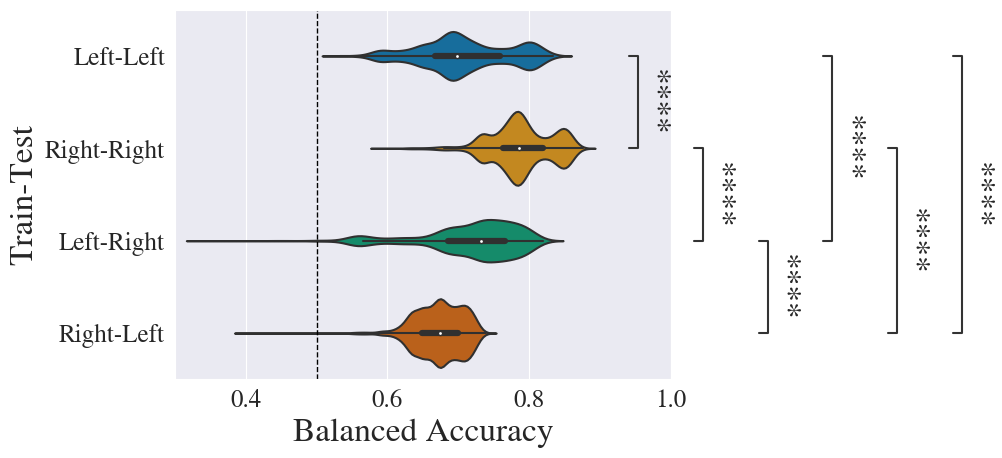

In [5]:
make_violin_accuracy(
    data=all_results_no_dummy,
    sides=order,
    path_to_save_fig="../final_visualizations/violin_nested_accuracy_usilaughs.pdf",
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
)


In [6]:
average_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].mean()
# NOTE: this error estimation is not actually correct.
err_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].std() / (all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].count().apply(lambda x: x**0.5))
for i in range(len(average_acc)):
    # print accuracy with format '0.2f' (2 decimal places)
    print('Average accuracy for {} side: {:.2f} ± {:.2f}'.format(average_acc.index[i], average_acc[i]*100, err_acc[i]*100))

Average accuracy for Left-Left side: 70.84 ± 0.11
Average accuracy for Left-Right side: 71.61 ± 0.13
Average accuracy for Right-Left side: 67.22 ± 0.06
Average accuracy for Right-Right side: 78.81 ± 0.08


In [7]:
max_acc = all_results_no_dummy.groupby('Train-Test').max()
display(max_acc)

,Model,Balanced Accuracy,Standard Error
Train-Test,,,
Left-Left,XGBClassifier,0.834444,0.068958
Left-Right,XGBClassifier,0.819722,1.000000
Right-Left,XGBClassifier,0.739444,1.000000
Right-Right,XGBClassifier,0.875833,0.088371


## MWC2022

In [8]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/nested_all.h5"

order = [
    "Left-Left",
    "Right-Right",
    "Left-Right",
    "Right-Left",
]
# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs)
all_results_no_dummy = remove_dummy(data=all_results)
all_results_no_dummy = clean_side_names(data=all_results_no_dummy)


Loading data:   0%|          | 0/1500 [00:00<?, ?it/s]

/tmp/ipykernel_572438/2960117792.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left-Left vs. Right-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.458e-133 U_stat=6.637e+06
Right-Right vs. Left-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.563e-134 U_stat=6.638e+06
Left-Right vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.963e-240 U_stat=2.524e+06
Left-Left vs. Left-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=8.315e+06
Right-Right vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.309e-11 U_stat=4.400e+06
Left-Left vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.510e-152 U_stat=6.754e+06


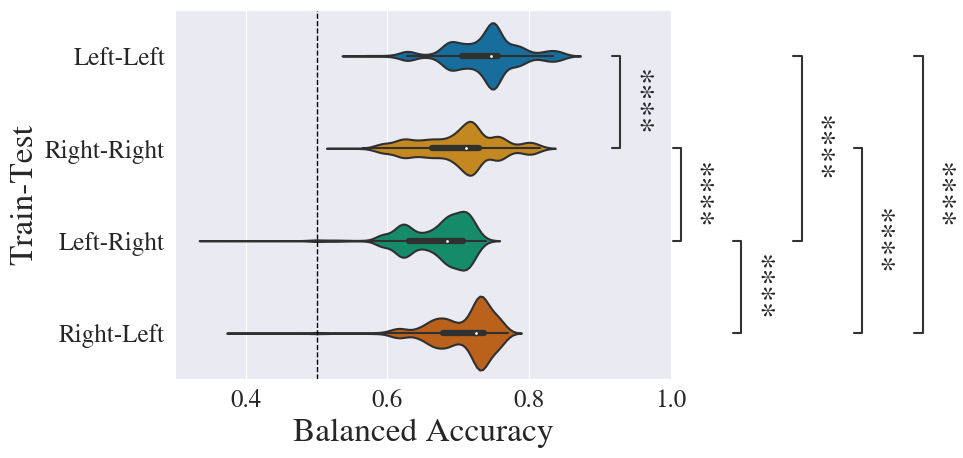

In [9]:
make_violin_accuracy(
    data=all_results_no_dummy,
    sides=order,
    path_to_save_fig="../final_visualizations/violin_nested_accuracy_mwc2022.pdf",
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
)


In [10]:
average_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].mean()
# NOTE: this error estimation is not actually correct.
err_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].std() / (all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].count().apply(lambda x: x**0.5))
for i in range(len(average_acc)):
    # print accuracy with format '0.2f' (2 decimal places)
    print('Average accuracy for {} side: {:.2f} ± {:.2f}'.format(average_acc.index[i], average_acc[i]*100, err_acc[i]*100))

Average accuracy for Left-Left side: 73.70 ± 0.09
Average accuracy for Left-Right side: 67.00 ± 0.08
Average accuracy for Right-Left side: 70.52 ± 0.09
Average accuracy for Right-Right side: 70.18 ± 0.10


In [11]:
max_acc = all_results_no_dummy.groupby('Train-Test').max()
display(max_acc)

,Model,Balanced Accuracy,Standard Error
Train-Test,,,
Left-Left,XGBClassifier,0.852486,0.060536
Left-Right,XGBClassifier,0.739617,1.000000
Right-Left,XGBClassifier,0.770070,1.000000
Right-Right,XGBClassifier,0.815008,0.066661
